# Unsupervised Algorithms in Document Clustering

#### Project code for the STATS 315B project of Thomas Brink and Quinn Hollister (unsupervised part)

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans, KMeans, SpectralCoclustering, SpectralClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import normalize as Norm
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score
from sklearn.utils.extmath import randomized_svd

from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix, dok_matrix, diags
from scipy.linalg import sqrtm, pinv

# Data Cleaning (Term-Document Matrix)

Should be in CCR or COO format

In [2]:
#First need to create a dictionary from dict.txt
dictionary = dict()
dictionaryFile = open("dictionary.txt")
while True:
  wordID = dictionaryFile.readline()
  if not wordID:
    break

  word, ID = wordID.split(" ")
  dictionary[int(ID)] = word

dict_length = len(dictionary)

In [3]:
#Now, go through wiki file and create dict so that we can convert to dataframe
#Or, equivalently a sparse matrix
wiki = dict()
wikiFile = open('tfidf.txt', 'r')
count = 0
while True:
  Line = wikiFile.readline()
  if not Line:
    break
  Title_Words = Line.split("|")
  Title = Title_Words[0]
  TFIDF = Title_Words[1].split(",")
  scores = [0]*dict_length
  for word_score in TFIDF:
    word_ID, score = word_score.split(":")
    scores[int(word_ID)] = float(score)
  wiki[Title] = scores

In [4]:
# Turn dictionary into datatable 
tableForm = pd.DataFrame.from_dict(wiki, orient = 'index')

In [5]:
#Word in dictionary that never appears in wiki need to remove
tableForm = tableForm.drop(columns = 2474)
TFIDFData = csr_matrix(tableForm)

## Descriptive Statistics

In [6]:
nrDocs = tableForm.shape[0]
nrWords = tableForm.shape[1]
print("Number of documents =", nrDocs)
print("Number of words =", nrWords)

Number of documents = 15902
Number of words = 10574


In [7]:
nonzeroTFIDFCount = csr_matrix.count_nonzero(TFIDFData)
sparsity = 1 - nonzeroTFIDFCount/(tableForm.shape[0]*tableForm.shape[1])
print("Sparsity percentage =", sparsity*100)
print("Number of unique document-word combinations =", nonzeroTFIDFCount)

Sparsity percentage = 99.59825688536726
Number of unique document-word combinations = 675522


In [8]:
meanTFIDF = np.mean(TFIDFData)
maxTFIDF = np.max(TFIDFData)
print("Mean TFIDF =", meanTFIDF)
print("Max TFIDF =", maxTFIDF)

Mean TFIDF = 0.004038653325799323
Max TFIDF = 9.674263049655917


In [9]:
npTFIDF = TFIDFData.toarray()

In [10]:
uniqWordsPerDoc = np.count_nonzero(npTFIDF, axis=1)
meanWordsPerDoc = np.mean(uniqWordsPerDoc)
minWordsPerDoc = np.min(uniqWordsPerDoc)
maxWordsPerDoc = np.max(uniqWordsPerDoc)
print("Average number of unique words per doc =", np.round(meanWordsPerDoc))
print("Minimum number of unique words per doc =", minWordsPerDoc)
print("Maximum number of unique words per doc =", maxWordsPerDoc)

Average number of unique words per doc = 42.0
Minimum number of unique words per doc = 10
Maximum number of unique words per doc = 586


### Data Inspection (Finding Rank of our Matrix)

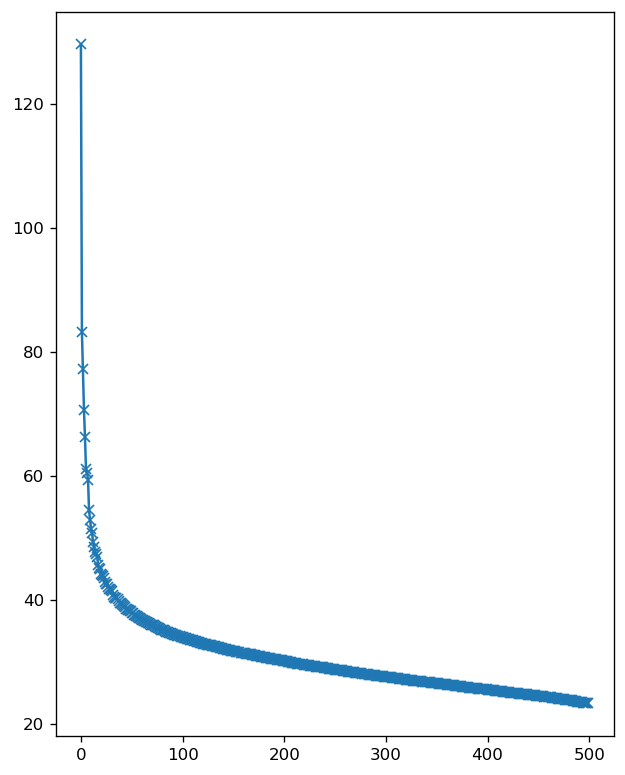

In [31]:
svd = TruncatedSVD(n_components = 500)
svd.fit(TFIDFData)
plt.plot(svd.singular_values_, label = "Singular Value Magnitudes", marker = "x")
fig = plt.gcf()
fig.set_size_inches((6,8))
fig.set_dpi(120)

In [32]:
svd.singular_values_[99:500:100]

array([33.98846254, 30.17645211, 27.6011066 , 25.55240314, 23.31153178])

In [47]:
svd.singular_values_[74]

35.62723968433808

# Clustering Methods

In [ ]:
pca_result = svd.transform(TFIDFData)
tSNE = TSNE(n_components=2)
tSNE_results = tSNE.fit_transform(pca_result)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
#Generate the Labels
subspaces = 5
dimension = 5
K = 5
B = 500
T = 3

labels = EKSS(TFIDFData, subspaces, dimension, K, B, T)

Completed 0 weak learners out of 750
Completed 75 weak learners out of 750
Completed 150 weak learners out of 750
Completed 225 weak learners out of 750
Completed 300 weak learners out of 750
Completed 375 weak learners out of 750
Completed 450 weak learners out of 750
Completed 525 weak learners out of 750
Completed 600 weak learners out of 750
Completed 675 weak learners out of 750
Creating Affinity Matrix
Running Spectral Clustering


In [ ]:
#BPlabels, _, _, cost = BiPartFit(TFIDFData.transpose(), 10, n_init_ = 50, returnCost = True)
KMlabels, _, cost = KMeansFit(TFIDFData, 5, returnCost = True)
#SVDlabels, _, _, cost = PCAkMeansFit(TFIDFData, 5, dimensions = 100, returnCost = True, normalize = False)

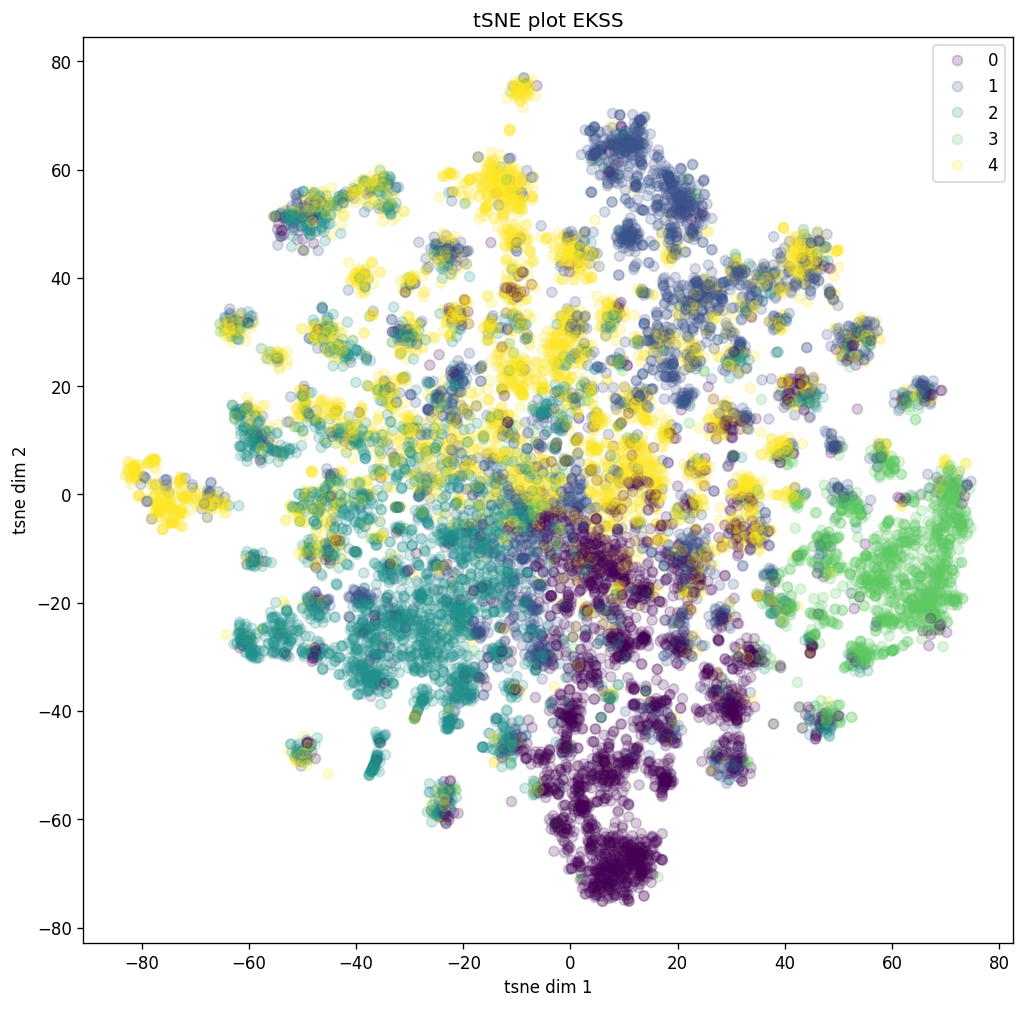

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(tSNE_results[:,0], tSNE_results[:,1], c = labels, alpha = 0.2)
                     
ax.legend(*scatter.legend_elements())
plt.title("tSNE plot EKSS")
plt.xlabel("tsne dim 1")
plt.ylabel("tsne dim 2")
fig.set_size_inches(10,10)
fig.set_dpi(120)

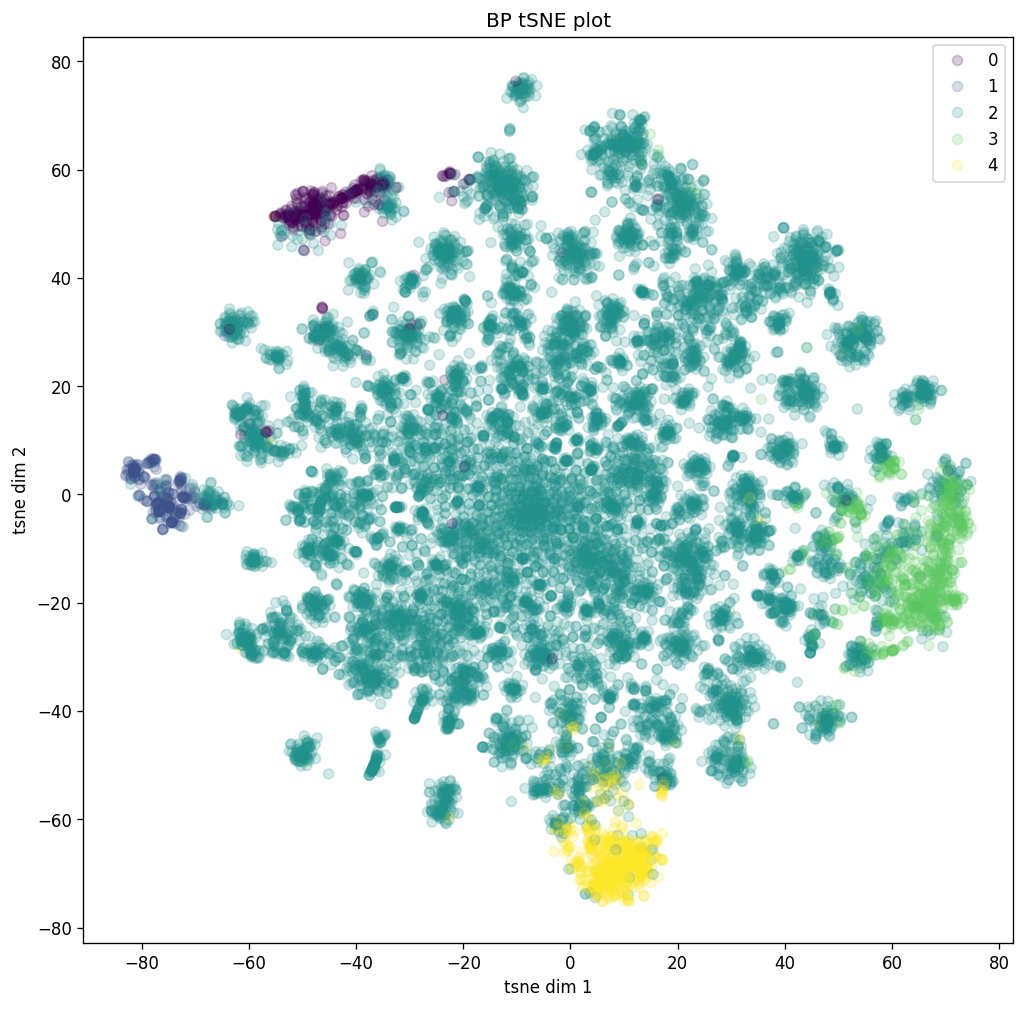

In [ ]:
fig, ax = plt.subplots()
scatter = ax.scatter(tSNE_results[:,0], tSNE_results[:,1], c = KMlabels, alpha = 0.2
                     )
ax.legend(*scatter.legend_elements())
plt.title("BP tSNE plot")
plt.xlabel("tsne dim 1")
plt.ylabel("tsne dim 2")
fig.set_size_inches(10,10)
fig.set_dpi(120)

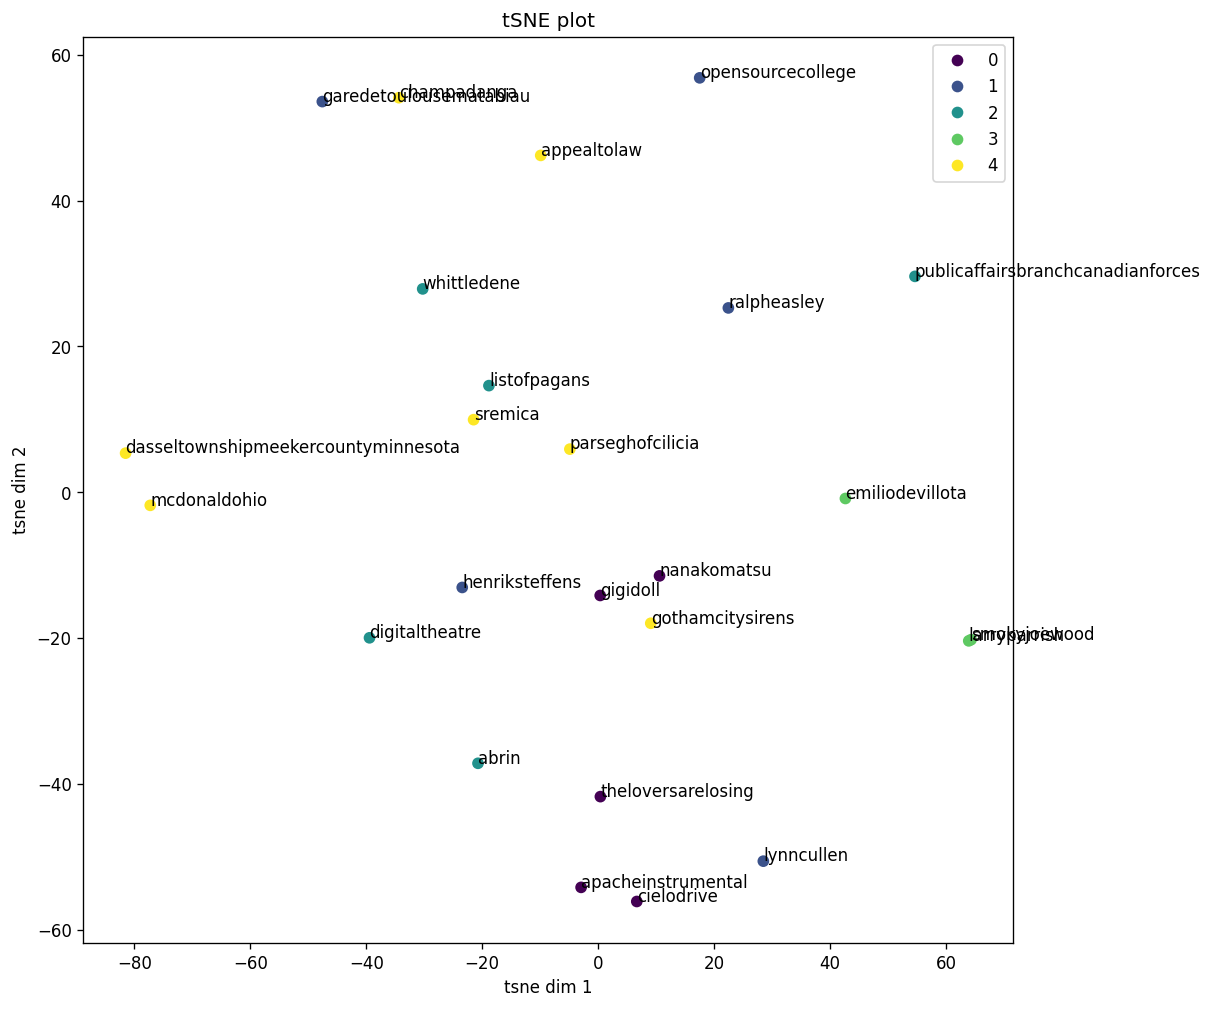

In [ ]:
SIZE = 25
np.random.seed(1)
randIdx = np.random.choice(tSNE_results.shape[0], SIZE, replace = False)
subsetResults = tSNE_results[randIdx]
subsetStrings = [list(tableForm.index)[val] for val in randIdx]


fig, ax = plt.subplots()
scatter = ax.scatter(subsetResults[:,0], subsetResults[:,1], c = labels[randIdx])

for i, txt in enumerate(subsetStrings):
    ax.annotate(txt, (subsetResults[i,0], subsetResults[i,1]))
                     
ax.legend(*scatter.legend_elements())
plt.title("tSNE plot")
plt.xlabel("tsne dim 1")
plt.ylabel("tsne dim 2")
fig.set_size_inches(10,10)
fig.set_dpi(120)

In [ ]:
#Create a plot that only focuses on the points in some subdomain
Xbox = [60,70]
Ybox = [-20,0]

SIZE = 15
points = np.ndarray((SIZE, 4))
subsetStrings = list()
randIdx = np.random.choice(tSNE_results.shape[0], SIZE*100, replace = False)


count = 0
for idx in randIdx:
  point = tSNE_results[idx, :]
  if Xbox[0] <= point[0] and point[0] <= Xbox[1] and Ybox[0] <= point[1] and point[1] <= Ybox[1] and count < SIZE:
    points[count,0] = point[0]
    points[count,1] = point[1]
    points[count,2] = idx
    subsetStrings.append(list(tableForm.index)[idx])
    count += 1


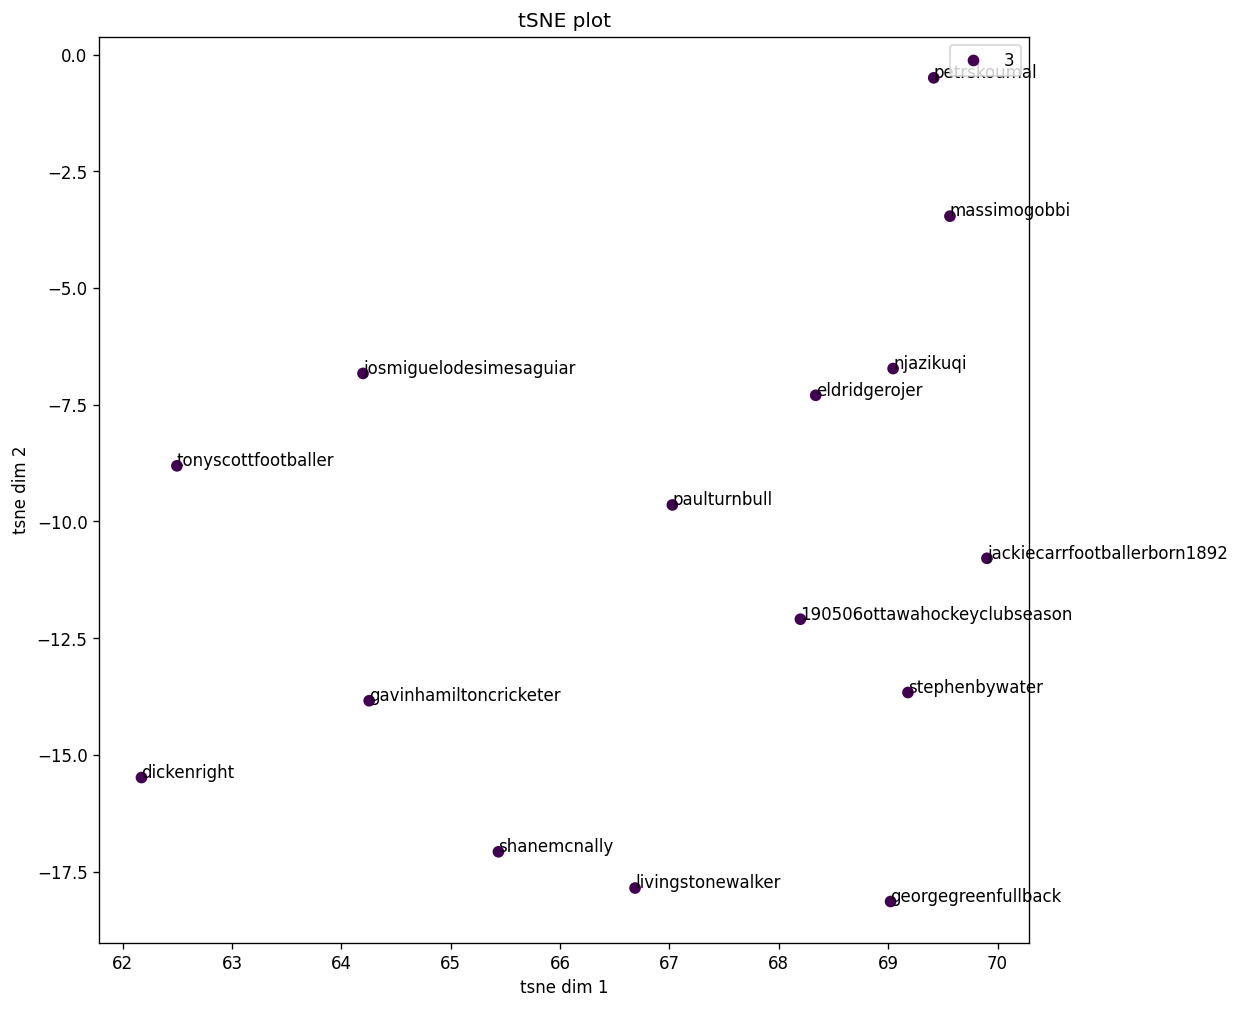

In [ ]:
fig, ax = plt.subplots()
idxs = [int(i) for i in points[:,2]]
colors = labels[idxs]
scatter = ax.scatter(points[:,0], points[:,1], c = colors)

for i, txt in enumerate(subsetStrings):
    ax.annotate(txt, (points[i,0], points[i,1]))
                     
ax.legend(*scatter.legend_elements())
plt.title("tSNE plot")
plt.xlabel("tsne dim 1")
plt.ylabel("tsne dim 2")
fig.set_size_inches(10,10)
fig.set_dpi(120)

## GMM

In [63]:
'''
GMMFit: Given data and number of clusters, runs GMM and returns labels for what cluster each row is in,
          and also the centroid points, (used for finding top documents)
  Params:
    1. Data, term-document matrix in csr format
    2. k, cluster size
    3. n_init_, number of different seeds we want to run our algo on
    
  Returns:
    1. Labels, vector of documents with cluster # that the document has been assigned to
    2. Centroid Points
'''
def GMMFit(data, k, n_init_ = 10, returnCost = False, normalize = True, passObject = False):
  #First renormalize all features to unit length so that we can use cosine similarity as the distance metric
  if normalize:
    data = Norm(data)

  #Now run the algorithm multiple times with different seeds, only keeping the run with the lowest heterogeneity
  gmmMod = GaussianMixture(n_components = k, covariance_type = 'diag', n_init = n_init_)
  final_cluster_assignment = gmmMod.fit_predict(data)
  cluster_centers = gmmMod.means_
  final_heterogeneity = gmmMod.bic(data)

  if returnCost and passObject:
    return final_cluster_assignment, cluster_centers, final_heterogeneity, kmeans
  elif returnCost:
    return final_cluster_assignment, cluster_centers, final_heterogeneity
  else:
    return final_cluster_assignment, cluster_centers


In [62]:
GMMFit(npTFIDF, 1)

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([[2.07813546e-04, 1.14011670e-04, 1.68481028e-03, ...,
         1.96360691e-04, 6.61802366e-04, 9.09855723e-05]]))

In [64]:
%%time 
#Let's run our GMM algorithm, varying k to get a BIC plot
clusters = [2, 3, 4, 5, 10, 15, 25, 50, 75, 100, 150]
GMMcostPerK = [0]*len(clusters)

for idx, k in enumerate(clusters):
  labels, _, cost = GMMFit(npTFIDF, k, returnCost = True)
  GMMcostPerK[idx] = cost
  print(f"Finished GMM with {k} clusters")

Finished GMM with 2 clusters
Finished GMM with 3 clusters
Finished GMM with 4 clusters
Finished GMM with 5 clusters
Finished GMM with 10 clusters
Finished GMM with 15 clusters
Finished GMM with 25 clusters
Finished GMM with 50 clusters
Finished GMM with 75 clusters
Finished GMM with 100 clusters
Finished GMM with 150 clusters
Wall time: 1h 36min 26s


In [73]:
clusters

[2, 3, 4, 5, 10, 15, 25, 50, 75, 100, 150]

In [72]:
GMMcostPerK

[-1274282994.6982439,
 -1333241551.8301475,
 -1339597633.7746897,
 -1356997221.9897983,
 -1450328933.4060912,
 -1518065127.620219,
 -1570132226.433249,
 -1653937259.8430846,
 -1684151460.88608,
 -1703622357.0907402,
 -1739231266.9589648]

In [67]:
labels, _, cost = GMMFit(npTFIDF, 200, returnCost = True)

In [68]:
cost

-1754174311.420174

In [70]:
labels, _, cost = GMMFit(npTFIDF, 350, returnCost = True)

In [71]:
cost

-1781715573.9290342

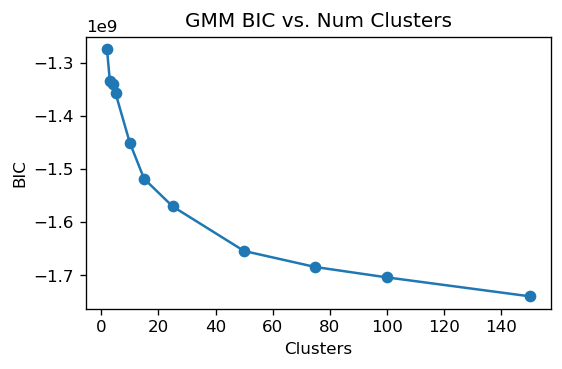

In [65]:
#Now lets examine the elbow plot
plt.plot(clusters, GMMcostPerK, "-o")
plt.title("GMM BIC vs. Num Clusters")
plt.xlabel("Clusters")
plt.ylabel("BIC")
fig = plt.gcf()
fig.set_size_inches((5,3))
fig.set_dpi(120)
plt.savefig("GMMBIC.png")

## Kmeans 




In [ ]:
'''
KMeansFit: Given data and number of clusters, runs Kmeans and returns labels for what cluster each row is in,
          and also the centroid points, (used for finding top documents)
  Params:
    1. Data, term-document matrix in csr format
    2. k, cluster size
    3. n_init_, number of different seeds we want to run our algo on
    
  Returns:
    1. Labels, vector of documents with cluster # that the document has been assigned to
    2. Centroid Points
'''
def KMeansFit(data, k, n_init_ = 25, returnCost = False, normalize = True, passObject = False):
  #First renormalize all features to unit length so that we can use cosine similarity as the distance metric
  if normalize:
    data = Norm(data)

  #Now run the algorithm multiple times with different seeds, only keeping the run with the lowest heterogeneity
  kmeans = KMeans(n_clusters = k, init = "k-means++", n_init = n_init_).fit(data)
  final_cluster_assignment = kmeans.labels_
  cluster_centers = kmeans.cluster_centers_
  final_heterogeneity = kmeans.inertia_

  if returnCost and passObject:
    return final_cluster_assignment, cluster_centers, final_heterogeneity, kmeans
  elif returnCost:
    return final_cluster_assignment, cluster_centers, final_heterogeneity
  else:
    return final_cluster_assignment, cluster_centers


## SVD Dim-Reduced KMeans



We will be preprocessing documents with PCA. We will make the number of components a parameter. 

In [ ]:
'''
SVDkMeansFit: Given data and number of clusters, runs Kmeans on reduced dimensions of the features (terms) and
returns labels for what cluster each row is in, and also the centroid points, (used for finding top documents)
  Params:
    1. Data, term-document matrix in csr format
    2. k, cluster size
    3. dimensions, number of singular vectors we want to compute
    4. n_init_, number of different seeds we want to run our algo on
    
  Returns:
    1. Labels, vector of documents with cluster # that the document has been assigned to
    2. Centroid Points
    3. object for projecting data points into embedded space
    4. Heterogeneity for kMeans 
'''
def PCAkMeansFit(data, k, dimensions = 20, n_init_ = 25, returnCost = False, normalize = False):
  svd = TruncatedSVD(n_components = dimensions)
  transformedData = svd.fit_transform(data)
  labels, cluster_centers, cost = KMeansFit(transformedData, k, n_init_, returnCost = returnCost, normalize = normalize)
  if returnCost:
    return labels, cluster_centers, svd, cost
  else:
    return labels, cluster_centers, svd


## Bipartite Spectral Graph Partitioning

Outline of Algorithm:

1. Given A, the word by document matrix, form D1(i,i) = ∑ⱼ Aᵢⱼ, and D2(j,j) = ∑ᵢ Aᵢⱼ. Finally, form Aₙ = D1^{-1/2} A D2^{-1/2}. 
2. Compute l = ceiling(log2 k) singular vectors of Aₙ: u2, ... , u{l+1}, v2, ... , v{l+1}. and form the matrix Z. Z = ( D1^{-1/2}U | D2^{-1/2}V )
3. Run K-means on the l-dimensional data to obtain the desired K-way partitioning. 

In [ ]:
'''
BiPartFit: Given data and number of clusters, runs Kmeans on reduced dimensions of the features (terms) and
returns labels for what cluster each row is in, and also the centroid points, (used for finding top documents)
  Params:
    1. Data, term-document matrix in csr format
    2. k, cluster size
    3. returnCost, do we want to know inertia score
    4. normalize, do we want to normalize the input to the KMeans algo
    
  Returns:
    1. Labels, vector of documents with cluster # that the document has been assigned to
    2. Centroid Points
    3. VT, how you can project the original document data onto the dim reduction 
    4. Heterogeneity for kMeans
'''
def BiPartFit(data, k, n_init_ = 50, returnCost = False, normalize = False, verbose = False):
  #We could normalize the data from term-frequencies to just whether words occur in a document or not, possibly explore


  #Form D1, An, D2
  numWords = data.shape[0]
  numDocs = data.shape[1]
  D1, An, D2 = FormComponents(data)

  num_components = int(np.ceil(np.log2(k)))
  print(f"Dimension of BiPartFit: {num_components}")

  #Compute the (2, l+1) right and left singular vectors
  U, S, VT = randomized_svd(An, n_components = num_components+1, random_state = None)

  #Drop the first right and left singular vectors
  U = U[:, 1:]
  VT = VT[1:,:]

  #Form Z
  Z = FormZ(D1, D2, U, VT)


  #Run Kmeans on the l-dimensional data to obtain K partitioning. 
  #Documents will be the rows of the Z from row (m+1) to the end. We can then use this mapping to get clusters of documents
  if returnCost:
    WordDocClusters, cluster_centers, _, kmeans = KMeansFit(Z, k, n_init_ = n_init_, returnCost = returnCost, normalize = normalize, passObject = True)
  else:
    WordDocClusters, cluster_centers = KMeansFit(Z, k, n_init_ = n_init_, returnCost = returnCost, normalize = normalize)

  DocClusters = WordDocClusters[numWords:]
  WordClusters = WordDocClusters[:numWords]
  if returnCost:
    cost = -1*kmeans.score(Z[numWords:])


  if verbose:
    TopDocs(Z[numWords:], DocClusters, cluster_centers, k, 5)


  if returnCost:
    return DocClusters, cluster_centers, VT, cost
  else:
    return DocClusters, WordClusters, cluster_centers, VT


def FormComponents(data):
  D1 = diags(np.ravel((np.power(data.sum(axis = 1), -1/2))), format = "csr")
  D2 = diags(np.ravel((np.power(data.sum(axis = 0), -1/2))), format = "csr")
  An = D1 @ data @ D2
  return D1, An, D2

def FormZ(D1, D2, U, VT):
  Z1 = D1@U
  Z2  = D2@(VT.transpose())
  Z = np.vstack((Z1, Z2))
  return Z



In [ ]:
"""
  Returns: vector corresponding to which basis had smallest projection distance
  Assumption: Bases is a list of matrices

  I might also want to keep track of the objective function descent
"""
def clustAssign(data, Bases):
  Distances = np.ndarray((data.shape[0], len(Bases)), dtype = float)
  for idx, U in enumerate(Bases):
    projection = data @ U
    proj_dist = np.linalg.norm(projection, axis = 1)
    Distances[:, idx] = np.ravel(proj_dist)
  closest_cluster = np.argmin(Distances, axis = 1)
  return closest_cluster


'''
  Returns a list (size subspaces) of bases given dimensions of data and dimensions of each individual basis element
'''
def drawRandomBases(ambientDim, basisDim, subspaces):
  subspaceList = list()
  for i in range(subspaces):
    points = np.random.normal(size = ambientDim*basisDim)
    X = np.reshape(points, (ambientDim, basisDim))
    U = X @ pinv((sqrtm(X.T @ X)))
    subspaceList.append(U)
  return subspaceList




'''
#  Returns a list (size subspaces) of bases given
'''
def drawSVDBases(data, clust_assignments, basisDim, subspaces):
  subspaceList = list()
  for i in range(subspaces):
    cluster = data[clust_assignments == i]
    U, _, VT = randomized_svd(cluster, n_components = basisDim, random_state = None)
    subspaceList.append(VT.T)

  return subspaceList



def affinityMatrix(cluster_assignments):
  distances = pairwise_distances(cluster_assignments, metric = "hamming")
  return 1 - distances

def checkBasis(data, Bases, subspaces):
  if Bases is None:
    return False
  clusters = clustAssign(data, Bases)
  for i in range(subspaces):
    count = data[clusters ==i].shape[0]
    if data[clusters == i].shape[0] < 5:
      return False
  return True




def EKSS(data, subspaces, dimension, K, B, T, q = 0):
  #Create an array that holds cluster assignments for each of our runs
  clust_assignments = np.ndarray((data.shape[0], B))

  #Fill Array
  for b in range(B):
    Bases = None
    while checkBasis(data, Bases, subspaces) is False:
      Bases = drawRandomBases(data.shape[1], dimension, subspaces)

    bClusters = clustAssign(data, Bases)
    for t in range(T):
      Bases = drawSVDBases(data, bClusters, dimension, subspaces)
      bClusters = clustAssign(data, Bases)

    if (b % int(B/10) == 0): 
      print(f"Completed {b} weak learners out of {B}")
    clust_assignments[:, b] = np.ravel(bClusters)
  

  #Create affinity matrix
  print("Creating Affinity Matrix")
  A = affinityMatrix(clust_assignments)
  print("Running Spectral Clustering")

  #Now run spectral clustering on this affinity matrix (assing_labels is hyperparameter, look at docs)
  clustering = SpectralClustering(n_clusters = K, assign_labels = 'kmeans', affinity = 'precomputed').fit(A)
  FinalClusters = clustering.labels_


  return FinalClusters

# Finding Optimal Clusters

## K-Means

In [ ]:
%%time 
#Let's run our KMeans algorithm, varying k to get an elbow plot
clusters = [2, 5, 10, 15, 25, 50, 75, 100, 150]
KMcostPerK = [0]*len(clusters)

for idx, k in enumerate(clusters):
  labels, _, cost = KMeansFit(TFIDFData, k, returnCost = True)
  KMcostPerK[idx] = cost
  print(f"Finished KMeans with {k} clusters")

Finished KMeans with 2 clusters
Finished KMeans with 5 clusters
Finished KMeans with 10 clusters
Finished KMeans with 15 clusters
Finished KMeans with 25 clusters
Finished KMeans with 50 clusters
Finished KMeans with 75 clusters
Finished KMeans with 100 clusters
Finished KMeans with 150 clusters
CPU times: user 19min 48s, sys: 1min 51s, total: 21min 40s
Wall time: 12min 46s


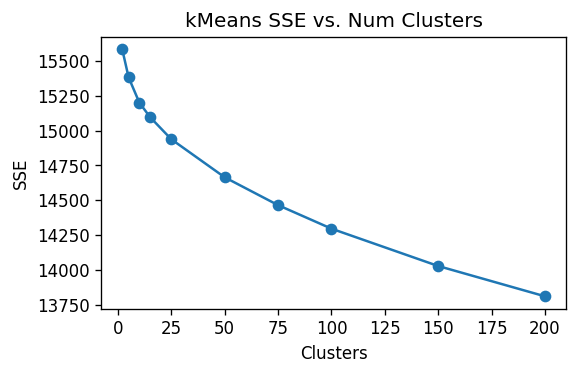

In [ ]:
#Now lets examine the elbow plot
plt.plot(clusters, KMcostPerK, "-o")
plt.title("kMeans SSE vs. Num Clusters")
plt.xlabel("Clusters")
plt.ylabel("SSE")
fig = plt.gcf()
fig.set_size_inches((5,3))
fig.set_dpi(120)
plt.savefig("kMeansSSE.png")

## PCA K-Means

In [ ]:
%%time 

#Let's run our PCAKMeans algorithm, varying k to get an elbow plot
#Note default dimensions is 20, Might want to create a 2D grid for hyperparameters
clusters = [2, 5, 10, 15, 25, 50, 75, 100, 150]
#dimensions = [5, 10, 15, 20, 25, 50, 75, 100]
dimensions = [50]
SVDcostPerKDim = np.ndarray((len(dimensions), len(clusters)))

for i, dim in enumerate(dimensions):
  for j, k in enumerate(clusters):
    labels, _, _, cost = PCAkMeansFit(TFIDFData, k, dimensions = dim, returnCost = True, normalize = False)
    SVDcostPerKDim[i, j] = cost
  print(f"Finished KMeans with {dim} dimensions")

Finished KMeans with 50 dimensions
CPU times: user 4min 54s, sys: 1min 25s, total: 6min 20s
Wall time: 3min 18s


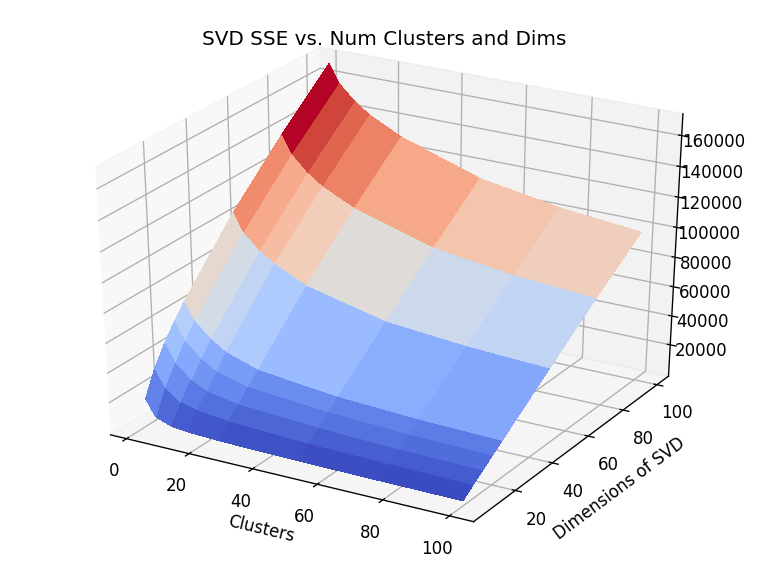

In [ ]:
#Now lets examine the elbow plot
X, Z = np.meshgrid(clusters, dimensions)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.plot_surface(X, Z, SVDcostPerKDim, cmap = cm.coolwarm,
                       linewidth=0, antialiased=False)
plt.title("SVD SSE vs. Num Clusters and Dims")
plt.xlabel("Clusters")
plt.ylabel("Dimensions of SVD")
fig = plt.gcf()
fig.set_size_inches((8,6))
fig.set_dpi(120)
plt.savefig("SVDSSE.png")

## BiPart Clustering

In [ ]:
%%time 
#Let's run our BP algorithm, varying k to get an elbow plot
clusters = [5, 10, 15, 25, 50, 75, 100, 150]
BPcostPerK = [0]*len(clusters)

for idx, k in enumerate(clusters):
  labels, _, _, cost = BiPartFit(TFIDFData.transpose(), k, n_init_ = 50, returnCost = True)
  BPcostPerK[idx] = cost
  print(f"Finished KMeans with {k} clusters")

In [ ]:
subspaces = 5
dimension = 5
K = 15
B = 250
T = 3

labels = EKSS(TFIDFData, subspaces, dimension, K, B, T)
print(labels)

Completed 0 weak learners out of 250
Completed 25 weak learners out of 250
Completed 50 weak learners out of 250
Completed 75 weak learners out of 250
Completed 100 weak learners out of 250
Completed 125 weak learners out of 250
Completed 150 weak learners out of 250
Completed 175 weak learners out of 250
Completed 200 weak learners out of 250
Completed 225 weak learners out of 250
Creating Affinity Matrix
Running Spectral Clustering
[12  0  2 ...  1 11  9]


In [ ]:
print(f"EKSS Silhouette Score: {silhouette_score(TFIDFData, labels)}")
print(f"EKSS DG Score: {davies_bouldin_score(TFIDFData.toarray(), labels)}")

EKSS Silhouette Score: -0.14463523576663928
EKSS DG Score: 12.224808526626797


In [ ]:
print(KMcostPerK)
print(SVDcostPerKDim)
print(BPcostPerK)

[15585.27298496072, 15378.89756412213, 15203.607894519819, 15096.852512374764, 14940.901200097964, 14671.983906818266, 14467.547892472543, 14298.347949962896, 14027.494716904634]
[[107885.52751899  96584.71168102  86275.02475426  79088.64881988
   69156.70916434  56744.1633569   52087.13149213  49036.35829539
   45684.82341516]]
[0.023781287294943915, 0.01778067580340007, 0.01340744196657297, 0.016032783273789795, 0.009665572012049765, 0.009370088206569163, 0.009139990522881943, 0.007220436447811529]


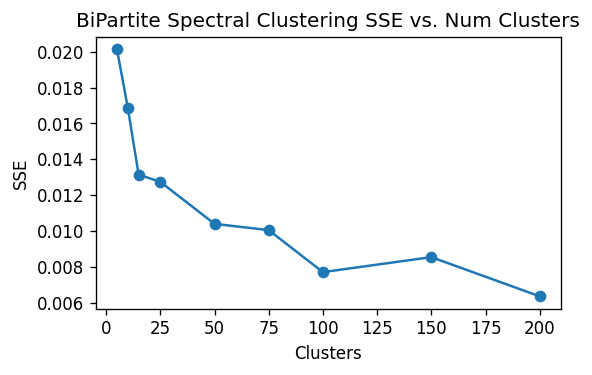

In [ ]:
#Now lets examine the elbow plot
plt.plot(clusters, BPcostPerK, "-o")
plt.title("BiPartite Spectral Clustering SSE vs. Num Clusters")
plt.xlabel("Clusters")
plt.ylabel("SSE")
fig = plt.gcf()
fig.set_size_inches((5,3))
fig.set_dpi(120)
plt.savefig("BPSSE.png")

#Evaluation Methods


## Silhouette Coefficient


This can be very tricky when we have different pre-processing methods, i.e. dimensionality reduction, and comparing silhouette scores across different dim reductions might not always make sense or be interpretable. 

## Top Words


In [ ]:
'''
TopWords returns the top words associated with the cluster assingments we find
Params:
  1. data, term-by-doc CSR matrix
  2. k, number of clusters
  3. centroids, location of the centers
  4. labels, array which tells us the cluster number that each doc is associated with
  5. numWords, how many words we want to find per cluster
  6. dict, dictionary relating indices to their words

Returns:
  1. void, just prints the words to screen
'''
def TopWords(data, labels, k, numWords, dictionary):
  for c in range(k):
    idxList = labels == c
    res = [i for i, val in enumerate(idxList) if val]
    wordStrength = data[res].sum(axis = 0).argsort()[::-1]
    print(f'Cluster {c}:')
    for i in range(min(numWords, len(wordStrength))):
      print(f'{dictionary[wordStrength[i]]}')
    print()


## Top Documents

In [ ]:
'''
TopDocs returns the top documents associated with the cluster assingments we find, i.e. ones with the shortest
  distance to their centroid
Params:
  1. data, term-by-doc CSR matrix
  2. labels, array which tells us the cluster number that each doc is associated with
  3. centroids, location of centroid  
  3. numDcs, how many documents we want to find per cluster
  4. transformer, if we have used dim reduction, then in order to find the closest we need to first transform

Returns:
  1. void, just prints the words to screen
'''

def TopDocs(data, labels, centroids, k, numDocs, transformer = None):
  if transformer is not None:
    data = transformer.transform(data)
  for c in range(k):
    print(f"cluster: {c}")
    distances = pairwise_distances(data, centroids[c].reshape(1, -1), metric='euclidean').flatten()
    distances[labels!=c] = float('inf') # remove non-members from consideration
    nearest_neighbors = distances.argsort()
    for i in range(numDocs):
      print(f'{list(tableForm.index)[nearest_neighbors[i]]}')
    print()

def ShowDocs(data, labels, k, numDocs, wordLabels = None, dictionary = None):
  for c in range(k):
    print(f'Cluster {c}: ')
    idxList = labels == c
    res = [i for i, val in enumerate(idxList) if val]
    for i in range(min(numDocs, len(res))):
      doc = list(tableForm.index)[res[i]]
      print(f'Document: {doc}')
    if wordLabels is not None:
      idx2List = wordLabels == c
      words = [i for i, val in enumerate(idx2List) if val] 
      for i in range(min(numDocs, len(words))):
        word = dictionary[words[i]]
        print(f'Word: {word}')
    print()


## Number of Documents in Clusters

In [ ]:
'''
clusterSizes returns a nparray with the number of documents in each cluster
Params:
  1. data, term-by-doc CSR matrix
  2. k, number of clusters
  3. labels, array which tells us the cluster number that each doc is associated with

Returns:
  1. sizes, nparray with the number of documents in each cluster
'''
def clusterSizes(data, k, labels):
  sizes = [0]*k
  for c in range(k):
    docList = labels == c
    docs = [i for i, val in enumerate(docList) if val]
    sizes[c] = len(docs)
  return sizes

# Model Evaluation

## Davies-Bouldin, Silhouette Metrics

DB has min value of zero, lower is better
Silhouette is between -1 and 1, -1 indicates clustering is wrong, 1 is perfect

In [ ]:
clusters = [50, 75, 100]
for k in clusters:  
  dim = 50
  KMeanslabels, _, cost = KMeansFit(TFIDFData, k, returnCost = True)
  SVDlabels, _, _, cost = PCAkMeansFit(TFIDFData, k, dimensions = dim, returnCost = True, normalize = False)
  BPlabels, _, _, cost = BiPartFit(TFIDFData.transpose(), k, returnCost = True)
  print(f"Cluster Size: {k}")
  print(f"Kmeans Silhouette Score: {silhouette_score(TFIDFData, KMeanslabels)}")
  print(f"SVD Silhouette Score: {silhouette_score(TFIDFData, SVDlabels)}")
  print(f"BP Silhouette Score: {silhouette_score(TFIDFData, BPlabels)}")
  print(f"Kmeans DG Score: {davies_bouldin_score(TFIDFData.toarray(), KMeanslabels)}")
  print(f"SVD DG Score: {davies_bouldin_score(TFIDFData.toarray(), SVDlabels)}")
  print(f"BP DG Score: {davies_bouldin_score(TFIDFData.toarray(), BPlabels)}")


Dimension of BiPartFit: 6
Cluster Size: 50
Kmeans Silhouette Score: -0.12229476197164953
SVD Silhouette Score: -0.08272922067701616
BP Silhouette Score: -0.19518077226497346
Kmeans DG Score: 8.074333122920663
SVD DG Score: 8.23936273551477
BP DG Score: 9.007278484933181
Dimension of BiPartFit: 7
Cluster Size: 75
Kmeans Silhouette Score: -0.1420866428326247
SVD Silhouette Score: -0.07983294196371286
BP Silhouette Score: -0.2378117383070366
Kmeans DG Score: 7.2321338559207895
SVD DG Score: 8.355155152831694
BP DG Score: 8.339235628966415
Dimension of BiPartFit: 7
Cluster Size: 100
Kmeans Silhouette Score: -0.11362844187069447
SVD Silhouette Score: -0.1229731202012836
BP Silhouette Score: -0.2084068175791676
Kmeans DG Score: 6.805335809798602
SVD DG Score: 8.108058643795395
BP DG Score: 7.905245592629072


In [74]:
clusters = [50, 100]
for k in clusters:  
  GMMlabels, _, GMMcost = GMMFit(npTFIDF, k, returnCost = True)
  print(f"Cluster Size: {k}")
  print(f"GMM Silhouette Score: {silhouette_score(TFIDFData, GMMlabels)}")
  print(f"GMM DG Score: {davies_bouldin_score(TFIDFData.toarray(), GMMlabels)}")

Cluster Size: 50
GMM Silhouette Score: -0.1211398830351086
BP DG Score: 9.36531607183833
Cluster Size: 100
GMM Silhouette Score: -0.1266224919259872
BP DG Score: 7.703641418864096


In [ ]:
%%time 
k = 100
dim = 50
KMeanslabels, _, cost = KMeansFit(TFIDFData, k, returnCost = True)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 13.4 µs


In [ ]:
%%time
SVDlabels, _, _, cost = PCAkMeansFit(TFIDFData, k, dimensions = dim, returnCost = True, normalize = False)

CPU times: user 1min 11s, sys: 26.9 s, total: 1min 38s
Wall time: 50.8 s


In [ ]:
%%time
BPlabels, _, _, cost = BiPartFit(TFIDFData.transpose(), k, returnCost = True)

Dimension of BiPartFit: 7
CPU times: user 2min 6s, sys: 56.7 s, total: 3min 3s
Wall time: 1min 34s


In [ ]:
BPlabels, WordLabels, _, _ = BiPartFit(TFIDFData.transpose(), k, returnCost = False)

Dimension of BiPartFit: 7


In [ ]:
ShowDocs(TFIDFData.toarray(), labels, 15, 15)

Cluster 0: 
Document: samsungi8910
Document: apalachicolanationalestuarineresearchreserve
Document: mucoussheathsofthetendonsaroundtheankle
Document: buildabird
Document: sellsideplatform
Document: wedbushsecurities
Document: jimfannin
Document: cubicmetre
Document: dockplate
Document: targetbenefit
Document: northeastairlines
Document: beamdump
Document: oceanbiogeographicinformationsystem
Document: erosioncorrosionofcopperwatertubes
Document: tden

Cluster 1: 
Document: okinawasatlargedistricthouseofcouncillors
Document: pieterhendrikvanzuylenvannijevelt
Document: britishcolumbiageneralelection1900
Document: ulsterarmycouncil
Document: clannireann
Document: regulationofinterceptionofcommunicationsandprovisionofcommunicationrelatedinformationact
Document: ernieschreiber
Document: humanrightsinspain
Document: victorianstateelection1988
Document: carmelomartnez
Document: jamesfrenchpatton
Document: priceincreaseandfamineresistancecommittee
Document: pomoa
Document: electoraldistrictofkw

In [ ]:
ShowDocs(TFIDFData.toarray(), BPlabels, k, 10, WordLabels, dictionary)

Cluster 0: 
Document: northernvirginiatrolleys
Document: casagrandesoil
Document: marquisdowns
Document: volumecontrastbrilliance
Document: minnabluff
Document: vernonfamily
Document: stjohnthebaptistleonardo
Document: 2ndmissourivolunteerinfantry
Document: jessietompkins
Document: quarringtonlincolnshire
Word: benning
Word: whitfield
Word: salad
Word: franklin
Word: jonesboro
Word: gallatin
Word: greenway
Word: osu
Word: butler
Word: antebellum

Cluster 1: 
Word: proclamation

Cluster 2: 
Document: zucchiuscrater
Document: loewycrater
Document: sechenovcrater
Document: webbcrater
Document: gerasimovichcrater
Document: leecrater
Document: horrebowcrater
Word: martyn

Cluster 3: 
Document: odalengopiccolo
Document: calcinaia
Document: cervaradiroma
Word: poem

Cluster 4: 
Document: alarligament
Document: firstmetatarsalbone
Document: posteriormeniscofemoralligament
Document: inferioranalnerves
Document: rimavestibuli
Document: hypoglossaltrigone
Word: dorlandspre
Word: sights
Word: mark

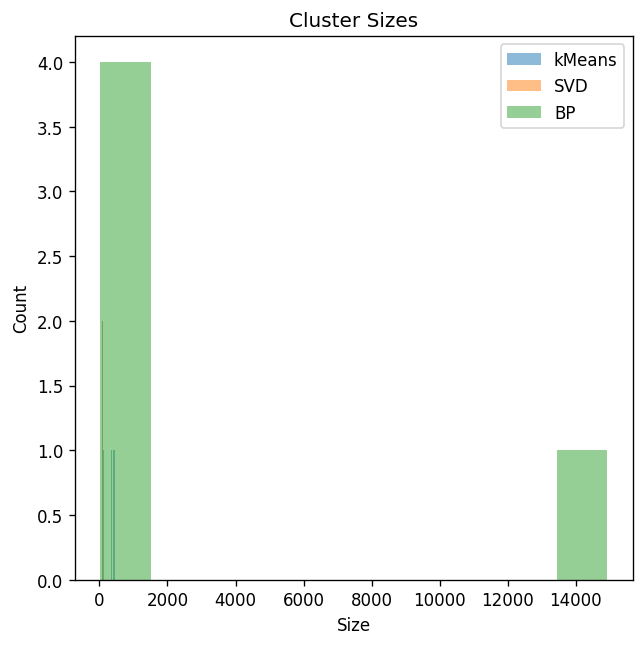

In [ ]:
KMeansClustSize = clusterSizes(TFIDFData, k, KMeanslabels)
SVDClustSize = clusterSizes(TFIDFData, k, SVDlabels)
BPClustSize = clusterSizes(TFIDFData, k, BPlabels)

plt.hist(KMeansClustSize, label = "kMeans", alpha = 0.5)
plt.hist(SVDClustSize, label = "SVD", alpha = 0.5)
plt.hist(BPClustSize, label = "BP", alpha = 0.5)

plt.title("Cluster Sizes")
plt.xlabel("Size")
plt.ylabel("Count")
plt.legend()

fig = plt.gcf()
fig.set_size_inches((6,6))
fig.set_dpi(120)

# Bibliography

1. https://www.kaggle.com/code/jbencina/clustering-documents-with-tfidf-and-kmeans/notebook

2. http://brandonrose.org/clustering

3. https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html

4. https://www.sciencedirect.com/science/article/pii/S1110866518301579

5. https://www.sciencedirect.com/science/article/pii/S153204641630185X

6. https://dl.acm.org/doi/pdf/10.1145/2133806.2133826

7. https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

8. https://www.sciencedirect.com/science/article/pii/S0957417419303598

9. https://stats.stackexchange.com/questions/420371/compare-clusters-quality-internal-validity-after-and-before-dimensionality-red

10. https://proceedings.neurips.cc/paper/2017/file/00a03ec6533ca7f5c644d198d815329c-Paper.pdf

11. https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.2.9775&rep=rep1&type=pdf